In [8]:
import numpy as np
import matplotlib.pyplot as plt
from basic_gan_trainer import BasicGANTrainer
from helper_functions import (save_network_data, recover_network_data, 
    load_disc_train_data, load_disc_test_data, generator_input, plot_image, 
    plot_value_functions)

trainer = BasicGANTrainer()

In [21]:
# recover_network_data('temp_info.npz', trainer)
# save_network_data('temp_info.npz', trainer)

In [10]:
disc_train_data = load_disc_train_data(5)
disc_test_data = load_disc_test_data(5)
n_train_samples = disc_train_data.shape[0]
n_test_samples = disc_test_data.shape[0]

In [11]:
batch_size = 64
num_batches = int(n_train_samples / batch_size)
num_epochs = 1

In [12]:
trainer.disc_forward_pass(trainer.gen_forward_pass(generator_input()))

array([[0.00045099]])

In [13]:
trainer.disc_forward_pass(disc_train_data[2][np.newaxis].T)

array([[0.96976216]])

In [22]:
for current_epoch in range(7):    
    for batch in range(num_batches):
        for train_example in range(0 + batch * batch_size, batch_size + batch * batch_size):
            trainer.disc_forward_pass(disc_train_data[train_example][np.newaxis].T)
            trainer.add_to_disc_value(1)
            trainer.calc_disc_grad(1, batch_size)

            trainer.disc_forward_pass(trainer.gen_forward_pass(generator_input()))
            trainer.add_to_disc_value(0)
            trainer.calc_disc_grad(0, batch_size)

        trainer.update_disc_value_array(batch_size)
        trainer.update_Thetas()

        for train_example in range(n_train_samples + batch * batch_size, n_train_samples + batch_size + batch * batch_size):
            trainer.disc_forward_pass(trainer.gen_forward_pass(generator_input()))
            trainer.add_to_gen_value()
            trainer.calc_gen_grad(batch_size)

        trainer.update_gen_value_array(batch_size)    
        trainer.update_Phis()

    print("Completed Epoch {}.".format(current_epoch + 1))


Completed Epoch 1.
Completed Epoch 2.
Completed Epoch 3.
Completed Epoch 4.
Completed Epoch 5.
Completed Epoch 6.
Completed Epoch 7.


In [23]:
trainer.disc_forward_pass(trainer.gen_forward_pass(generator_input()))

array([[0.0001]])

In [24]:
trainer.disc_forward_pass(disc_test_data[2][np.newaxis].T)

array([[0.9999]])

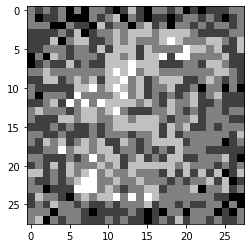

In [25]:
plot_image(trainer.gen_forward_pass(generator_input()))

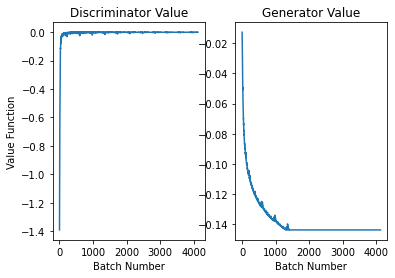

In [26]:
plot_value_functions(trainer)

In [19]:
n_train_samples

24000